In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

First, we need to add a new neuron model to nengo.  It has a RectifiedLinear neuron already, but it doesn't have an option to set a threshold.  So here we just subclass that model and create that parameter.

Note that we could also do something similar to set a maximum output for the ReLU as well.

In [2]:
class RectifiedLinearWithThreshold(nengo.RectifiedLinear):
    threshold = nengo.params.NumberParam('threshold')

    def __init__(self, amplitude=1, threshold=0):
        super().__init__(amplitude=amplitude)
        self.threshold = threshold

    def step_math(self, dt, J, output):
        output[...] = self.amplitude * np.where(J>self.threshold, J, 0)
        
class LeakyIntegrator(nengo.LIF):
    threshold = nengo.params.NumberParam('threshold')
    
    def __init__(self, amplitude=1, threshold=0, tau_rc=0.02, min_voltage=0):
        super().__init__(amplitude=amplitude, tau_rc=tau_rc, tau_ref=0, min_voltage=min_voltage)
        self.threshold = threshold
        
    def step_math(self, dt, J, output, voltage, refractory_time):
        output[:] = np.where(voltage>self.threshold, voltage, 0)
        
        dv = -voltage + output + J
        
        voltage += dv*(dt/self.tau_rc)
        
        voltage[voltage < self.min_voltage] = self.min_voltage

Now we build our model.  We have four basic "layers":  the image, the residual, v1, and the reconstruction.


In [9]:
seed = 4
np.random.seed(seed=seed)

N = 10    # size of the input
J = 50    # number of neurons

# generate an example image
span = np.linspace(0, 1, N)
image = (np.sin(2*np.pi*span)+1)/2

model = nengo.Network(seed=seed)
with model:
    # the input, which will be N-dimensional 
    #  (note that we can replace this with input that changes over time to give a more real-world example)
    stim = nengo.Node(image)
    
    # for the residual, we use N neurons which are ReLU neurons with a threshold of -infinity.  That is, 
    # there is no nonlinearity here at all.
    residual = nengo.Ensemble(n_neurons=N, dimensions=1,
                          neuron_type=RectifiedLinearWithThreshold(threshold=-np.inf),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
    
    # since the weight matrix in changing, we should also have a layer that is just the reconstruction    
    reconstruct = nengo.Ensemble(n_neurons=N, dimensions=1,
                          neuron_type=RectifiedLinearWithThreshold(threshold=-np.inf),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
    
    # here are the actual neurons, ReLUs with a slight positive threshold
    v1 = nengo.Ensemble(n_neurons=J, dimensions=1,
                          neuron_type=LeakyIntegrator(threshold=0.1, tau_rc=0.001),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
    # this connection turns the v1 neurons into integrators, since we will have v1[t+1] = v1[t]+input
    # if we wanted a leaky integrator, we could add transform=0.99, which would mean v1[t+1]=v1[t]*0.99+input
    #nengo.Connection(v1.neurons, v1.neurons, synapse=0)

    # the initial dictionary
    w = np.random.uniform(-0.1, 0.1, (J, N))
    
    # now we make the learning connections.  Nengo has Oja built in, which is Hebbian with a 
    # stabilizing factor.  We can set beta=0 to get rid of that factor, to make it just Hebbian.
    learning_rate=0.1
        
    tau = 0        # low-pass filter to use when using the w matrix
    tau_learn = 0  # low-pass filter to use when computing the Hebbian update
        
    nengo.Connection(residual.neurons, v1.neurons, transform=w, synapse=tau,
                     learning_rule_type=nengo.Oja(beta=0, pre_synapse=tau_learn, post_synapse=tau_learn, learning_rate=learning_rate))
        
    nengo.Connection(v1.neurons, reconstruct.neurons, transform=w.T, synapse=tau,
                     learning_rule_type=nengo.Oja(beta=0, pre_synapse=tau_learn, post_synapse=tau_learn, learning_rate=learning_rate))
    
    # subtract the reconstruction from the stim to get the residual layer
    nengo.Connection(stim, residual.neurons, synapse=0)
    nengo.Connection(reconstruct.neurons, residual.neurons, transform=-1, synapse=None)
    
    # record data from each layer
    p_v1 = nengo.Probe(v1.neurons)
    p_res = nengo.Probe(residual.neurons)
    p_recon = nengo.Probe(reconstruct.neurons)
    
    
sim = nengo.Simulator(model)
sim.run(15.0)
                        

c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

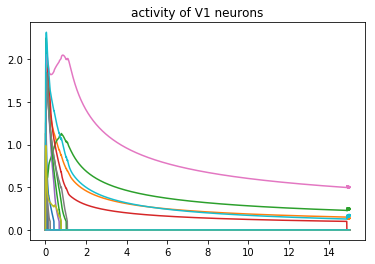

In [10]:
plt.plot(sim.trange(), sim.data[p_v1])
plt.title('activity of V1 neurons')
plt.show()

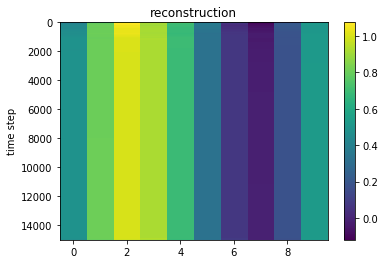

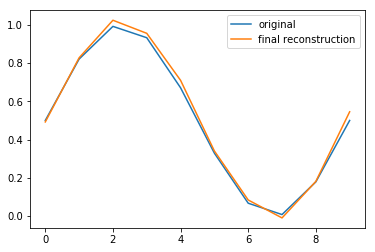

In [11]:
recon = sim.data[p_recon]
plt.imshow(recon, aspect='auto')
plt.ylabel('time step')
plt.title('reconstruction')
plt.colorbar()
plt.figure()
plt.plot(image, label='original')
plt.plot(recon[-1], label='final reconstruction')
plt.legend()
plt.show()


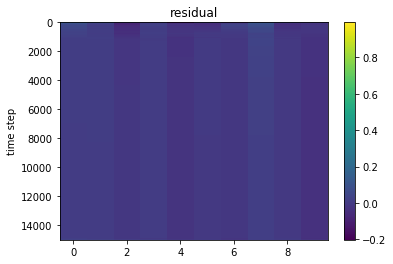

In [12]:
plt.imshow(sim.data[p_res][:,:], aspect='auto')
plt.ylabel('time step')
plt.title('residual')
plt.colorbar()


Text(0.5, 1.0, 'V1')

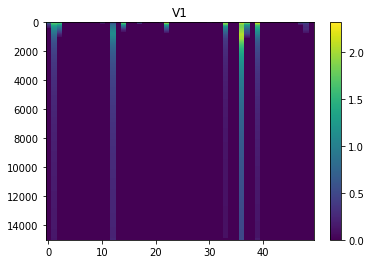

In [13]:
plt.imshow(sim.data[p_v1], aspect='auto')
plt.colorbar()
plt.title('V1')